In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings("ignore")

In [2]:
from imblearn.under_sampling import RandomUnderSampler

In [3]:
data_dir = "./datasets/"

In [4]:
df = pd.read_csv(data_dir+"pitchdf_ready_preds.csv")
df["game_date"] = pd.to_datetime(df["game_date"])
df = df[(df["1_day_lag_season_sum_ab"]>35)&(df["pitcher_total_batters_faced"]>50)]

In [5]:
df = df.sort_values("game_date")

In [6]:
player_id_name = pd.read_csv(data_dir+"player_id_name.csv")
player_id_name_dict = dict(zip(list(player_id_name["id"].values),list(player_id_name["fullName"].values)))

In [7]:
df["events"].value_counts()

field_out                    104385
strikeout                     58178
single                        36825
walk                          20325
double                        11407
home_run                       8346
force_out                      4884
grounded_into_double_play      4751
hit_by_pitch                   2807
sac_fly                        1675
field_error                    1532
triple                         1002
sac_bunt                        571
fielders_choice                 525
double_play                     505
truncated_pa                    419
fielders_choice_out             393
strikeout_double_play           157
catcher_interf                  126
sac_fly_double_play              23
triple_play                       3
Name: events, dtype: int64

In [8]:
df.loc[df["events"].isin(['fielders_choice_out', 'force_out','grounded_into_double_play',
                         'triple_play']),"events"] = "field_out"

df.loc[df["events"].isin(['strikeout_double_play']),"events"] = "strikeout"


In [9]:
events_list = ['strikeout','field_out', 'single', 'home_run', 'walk',
        'double',
       'triple',]

In [10]:
events_df = df[["batter","game_pk","pitcher","events",'at_bat_number']].dropna().groupby(["game_pk","at_bat_number"])["events"].value_counts()
events_df = pd.DataFrame(list(events_df.index),columns=["game_pk","at_bat_number","at_bat_result"])
df = df.merge(events_df,on=["game_pk","at_bat_number"])
df = df[df["at_bat_result"].isin(events_list)]

In [11]:
df.loc[df["at_bat_result"].isin(["double","triple"]),"at_bat_result"] = "double_triple"

In [12]:
encoder_dict = { 'single':0, 'double_triple':1,'home_run':2,'walk':3, 'field_out':4,'strikeout':5}

In [13]:
df['at_bat_result_encoded'] = df['at_bat_result'].apply(lambda x: encoder_dict[x])

In [14]:
# Features and target
features = ['balls', 'strikes', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up',
            'batter_walk_rate', 'batter_strikeout_rate',
            'batter_singles_average',
                                    'batter_home_run_average',
           'pitcher_walk_rate', 'pitcher_strikeout_percentage',
       'pitcher_batting_average_against', 'pitcher_home_run_average']
target = 'at_bat_result_encoded'
df = df.dropna(subset=features)


In [15]:

# Split into training and test sets
train_size = 0.8
split_index = int(len(df) * train_size)

df_train = df.iloc[:split_index].copy()
df_test = df.iloc[split_index:].copy()

# Now apply resampling only on the training set
X_train = df_train[features]  # Features
y_train = df_train[target]  # Target variable

sampling_strategy = {
    0: int(0.6*y_train.value_counts()[0]),
    1: int(0.2*y_train.value_counts()[0]), 
    2: int(0.2*y_train.value_counts()[0]), 
    3: int(0.6*y_train.value_counts()[0]),
    4: int(0.75*y_train.value_counts()[0]),
    5: int(0.65*y_train.value_counts()[0])
}


# Initialize the RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)

# Resample the training data
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [16]:
# Now apply resampling only on the training set
X_test = df_test[features]  # Features
y_test = df_test[target]  # Target variable

In [17]:
# Initialize KFold for cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Initialize models and their hyperparameter grids
param_grids = {
    'XGBoost': {
        'n_estimators': randint(100, 500),
        'learning_rate': uniform(0.01, 0.3),
        'max_depth': randint(3, 10),
        'subsample': uniform(0.5, 1),
        'colsample_bytree': uniform(0.5, 1)
    },
    'LogisticRegression': {
        'C': uniform(0.01, 10),
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
}

In [18]:
# Initialize models
models = {
    'XGBoost': XGBClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=500, random_state=42)
}

In [19]:
# Perform hyperparameter tuning and training using RandomizedSearchCV
best_models = {}
for name, model in models.items():
    print(f"\nTuning hyperparameters for {name}...")
    
    # Set up RandomizedSearchCV
    randomized_search = RandomizedSearchCV(estimator=model, param_distributions=param_grids[name], 
                                           n_iter=30, cv=kf, random_state=42, scoring='f1_micro', n_jobs=18,verbose=2)
    
    # Fit the RandomizedSearchCV to find the best hyperparameters
    randomized_search.fit(X_train_resampled, y_train_resampled)
    
    # Store the best model
    best_models[name] = randomized_search.best_estimator_
    
    # Print best parameters
    print(f"Best parameters for {name}: {randomized_search.best_params_}")
    
    # Predict using the best model
    y_pred = randomized_search.predict(X_test)
    
    # Classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))



Tuning hyperparameters for XGBoost...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters for XGBoost: {'colsample_bytree': 0.7184404372168336, 'learning_rate': 0.13495298436110986, 'max_depth': 8, 'n_estimators': 430, 'subsample': 0.824345021005274}

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.13      0.14     24665
           1       0.05      0.00      0.00      7892
           2       0.07      0.00      0.01      5438
           3       0.29      0.37      0.32     23386
           4       0.45      0.50      0.47     77261
           5       0.41      0.41      0.41     57723

    accuracy                           0.38    196365
   macro avg       0.24      0.24      0.23    196365
weighted avg       0.35      0.38      0.36    196365


Tuning hyperparameters for LogisticRegression...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters for LogisticRegressio

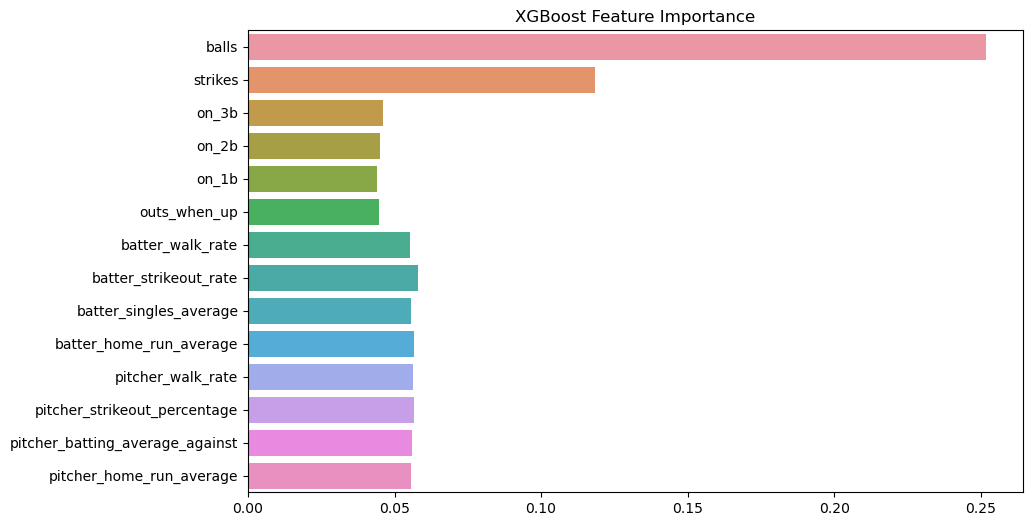

In [20]:
# Feature importance for tree-based models (RandomForest and XGBoost)
for name, model in best_models.items():
    if hasattr(model, 'feature_importances_'):
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        sns.barplot(x=model.feature_importances_, y=X_train.columns)
        plt.title(f"{name} Feature Importance")
        plt.show()

In [21]:
model_to_save = best_models['XGBoost']

In [22]:
import joblib

# Save the model
joblib.dump(model_to_save, 'best_xgboost_model.pkl')

['best_xgboost_model.pkl']

In [23]:
at_bat_result_df = df[["at_bat_result",'at_bat_result_encoded']].drop_duplicates().sort_values("at_bat_result_encoded")

In [24]:
dict(zip(at_bat_result_df["at_bat_result_encoded"].values,at_bat_result_df["at_bat_result"].values))

{0: 'single',
 1: 'double_triple',
 2: 'home_run',
 3: 'walk',
 4: 'field_out',
 5: 'strikeout'}

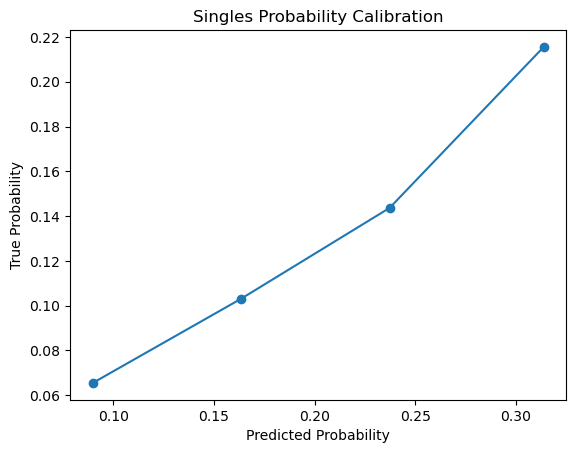

In [36]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_test == 0, model.predict_proba(X_test)[:, 0], n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Singles Probability Calibration")
plt.show()

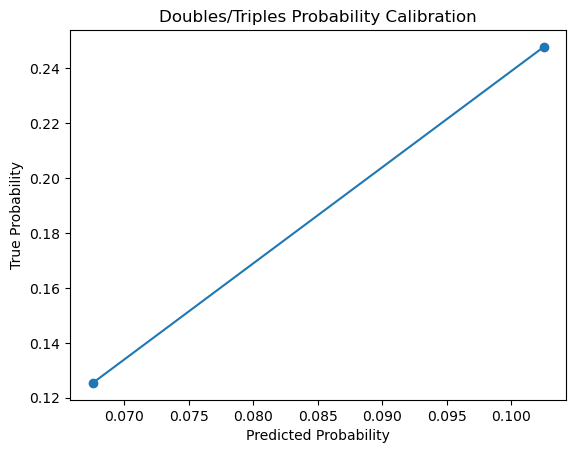

In [44]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_test == 0, model.predict_proba(X_test)[:, 1], n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Doubles/Triples Probability Calibration")
plt.show()

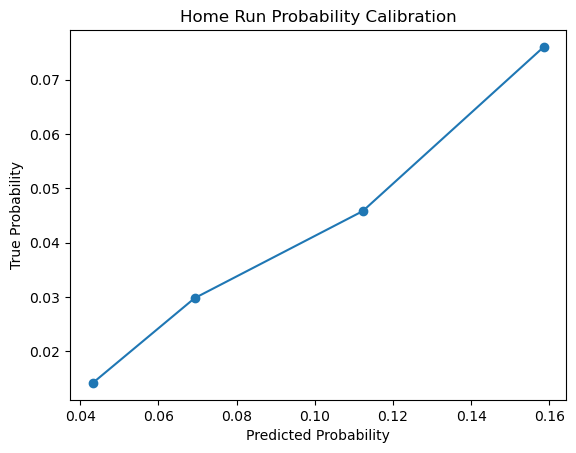

In [48]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_test == 2, model.predict_proba(X_test)[:, 2], n_bins=20)
plt.plot(prob_pred, prob_true, marker='o')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Home Run Probability Calibration")
plt.show()

In [49]:
prob_true, prob_pred

(array([0.01422241, 0.02980069, 0.04580766, 0.076     ]),
 array([0.04323743, 0.06924871, 0.1122537 , 0.15853836]))

In [51]:
df.columns

Index(['game_date', 'game_pk', 'batter', 'pitcher', 'events', 'description',
       'zone', 'pitch_type', 'balls', 'strikes', 'game_year', 'on_3b', 'on_2b',
       'on_1b', 'outs_when_up', 'hit_distance_sc', 'launch_speed',
       'launch_angle', 'effective_speed', 'estimated_ba_using_speedangle',
       'estimated_woba_using_speedangle', 'woba_value', 'woba_denom',
       'babip_value', 'iso_value', 'launch_speed_angle', 'at_bat_number',
       'pitch_number', 'swinging_strike', 'hit_into_play', 'foul',
       'batter_batting_average', 'batter_walk_rate', 'batter_strikeout_rate',
       'batter_contact_rate', 'batter_slugging_percent',
       'batter_on_base_percentage', 'batter_whiff_rate',
       'batter_singles_average', 'batter_doubles_triple_average',
       'batter_home_run_average', '1_day_lag_season_sum_ab',
       'pitcher_walk_rate', 'pitcher_era', 'pitcher_strikeout_percentage',
       'pitcher_batting_average_against', 'pitcher_home_run_average',
       'pitcher_total_batt

In [57]:
df.sort_values(["game_pk",'at_bat_number',
       'pitch_number'])[[ 'batter', 'pitcher',"at_bat_number", 'balls', 'strikes', 'batter_walk_rate','pitcher_strikeout_percentage','at_bat_result']].tail(21)

,batter,pitcher,at_bat_number,balls,strikes,batter_walk_rate,pitcher_strikeout_percentage,at_bat_result
500946,596146,663855,64,0,0,0.075972,0.283217,strikeout
500947,596146,663855,64,0,1,0.075972,0.283217,strikeout
500948,596146,663855,64,0,2,0.075972,0.283217,strikeout
500949,621043,663855,66,0,0,0.083807,0.283217,single
500950,621043,663855,66,1,0,0.083807,0.283217,single
500951,621043,663855,66,1,1,0.083807,0.283217,single
500952,621043,663855,66,2,1,0.083807,0.283217,single
500953,680777,663855,67,0,0,0.078481,0.283217,walk
500958,680777,663855,67,0,1,0.078481,0.283217,walk
500957,680777,663855,67,0,2,0.078481,0.283217,walk
